In [95]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [97]:
import tonic
import torchvision

sensor_size = tonic.datasets.NMNIST.sensor_size
frame_transform = tonic.transforms.ToFrame(sensor_size=sensor_size, time_window=1000)

trainset = tonic.datasets.NMNIST(save_to="./data", train=True)
testset = tonic.datasets.NMNIST(
    save_to="./data", transform=frame_transform, train=False
)

In [99]:
events = trainset[0][0]
events

array([(10, 30,    937, 1), (33, 20,   1030, 1), (12, 27,   1052, 1), ...,
       ( 7, 15, 302706, 1), (26, 11, 303852, 1), (11, 17, 305341, 1)],
      dtype=[('x', '<i8'), ('y', '<i8'), ('t', '<i8'), ('p', '<i8')])

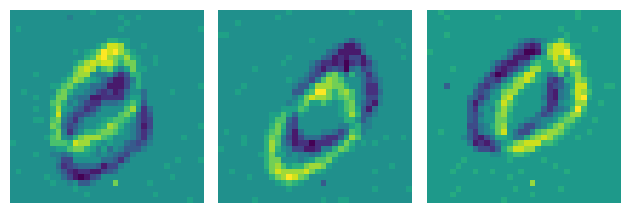

In [101]:
tonic.utils.plot_event_grid(events)

In [103]:
trainset[0][1]

0

In [105]:
# reduce this number if you run out of GPU memory
BATCH_SIZE = 32

# add sparse transform to trainset, previously omitted because we wanted to look at raw events
trainset.transform = frame_transform

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    collate_fn=tonic.collation.PadTensors(batch_first=False),
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    collate_fn=tonic.collation.PadTensors(batch_first=False),
    shuffle=False,
)

In [107]:
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell

# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState

from typing import NamedTuple


class SNNState(NamedTuple):
    lif0: LIFState
    readout: LIState


class SNN(torch.nn.Module):
    def __init__(
        self,
        input_features,
        hidden_features,
        output_features,
        tau_syn_inv,
        tau_mem_inv,
        record=False,
        dt=1e-3,
    ):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(
                alpha=100,
                v_th=torch.as_tensor(0.3),
                tau_syn_inv=tau_syn_inv,
                tau_mem_inv=tau_mem_inv,
            ),
            dt=dt,
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record

    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
                LIFState(
                    z=torch.zeros(seq_length, batch_size, self.hidden_features),
                    v=torch.zeros(seq_length, batch_size, self.hidden_features),
                    i=torch.zeros(seq_length, batch_size, self.hidden_features),
                ),
                LIState(
                    v=torch.zeros(seq_length, batch_size, self.output_features),
                    i=torch.zeros(seq_length, batch_size, self.output_features),
                ),
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
                self.recording.lif0.z[ts, :] = s1.z
                self.recording.lif0.v[ts, :] = s1.v
                self.recording.lif0.i[ts, :] = s1.i
                self.recording.readout.v[ts, :] = so.v
                self.recording.readout.i[ts, :] = so.i
            voltages += [vo]

        return torch.stack(voltages)

In [109]:
example_snn = SNN(
    np.product(trainset.sensor_size),
    100,
    len(trainset.classes),
    tau_syn_inv=torch.tensor(1 / 1e-2),
    tau_mem_inv=torch.tensor(1 / 1e-2),
    record=True,
    dt=1e-3,
)

frames, target = next(iter(train_loader))

frames[:, :1].shape

torch.Size([310, 1, 2, 34, 34])

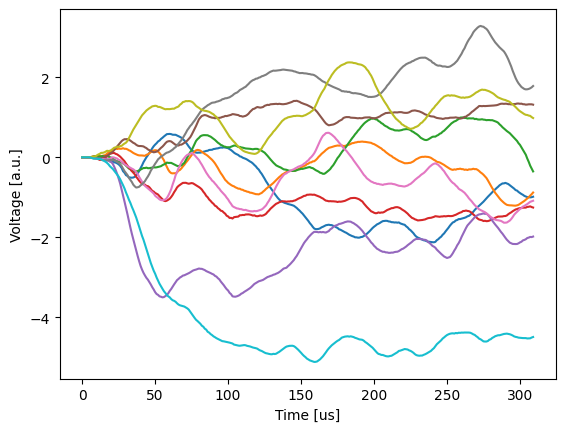

In [111]:
example_readout_voltages = example_snn(frames[:, :1])
voltages = example_readout_voltages.squeeze(1).detach().numpy()

plt.plot(voltages)
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [us]")
plt.show()

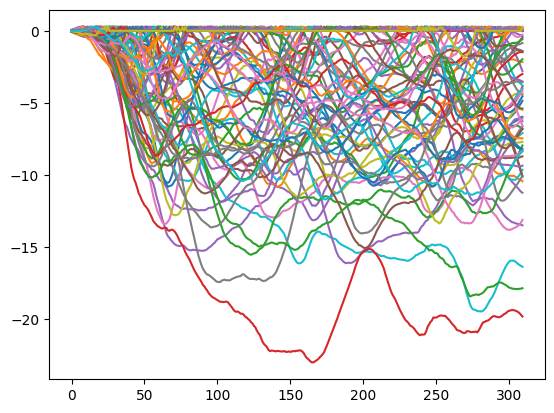

In [112]:
plt.plot(example_snn.recording.lif0.v.squeeze(1).detach().numpy())
plt.show()

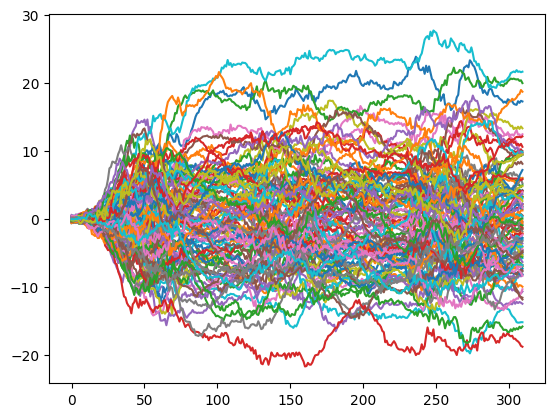

In [113]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

Final accuracy: 95.78%

Anmerkung: Ausführungszeit = 4 Stunden

In [119]:
import torch
from tqdm.notebook import tqdm
import numpy as np
import tonic


In [121]:
# Hyperparameter
BATCH_SIZE = 64
LR = 0.002
HIDDEN_FEATURES = 100
EPOCHS = 10

# Setze Sparse-Transformation für den Trainingsdatensatz
trainset.transform = frame_transform

# DataLoader erstellen
def create_data_loader(dataset, batch_size, shuffle=False):
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=tonic.collation.PadTensors(batch_first=False),
        shuffle=shuffle,
    )

train_loader = create_data_loader(trainset, BATCH_SIZE, shuffle=True)
test_loader = create_data_loader(testset, BATCH_SIZE)


In [123]:
# Decoder-Funktion
def decode(x):
    return torch.nn.functional.log_softmax(torch.max(x, 0)[0], dim=1)


In [125]:
# Modellklasse
class Model(torch.nn.Module):
    def __init__(self, snn):
        super(Model, self).__init__()
        self.snn = snn

    def forward(self, x):
        return decode(self.snn(x))


In [127]:
# Gerät auswählen
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modell initialisieren
INPUT_FEATURES = np.product(trainset.sensor_size)
OUTPUT_FEATURES = len(trainset.classes)

model = Model(
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
        tau_syn_inv=torch.tensor(1 / 1e-2),
        tau_mem_inv=torch.tensor(1 / 1e-2),
    )
).to(DEVICE)


In [129]:
# Optimierer initialisieren
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [131]:
# Trainings- und Testfunktion
def run_epoch(model, device, data_loader, optimizer=None):
    if optimizer:
        model.train()
    else:
        model.eval()

    losses = []
    correct = 0

    with torch.set_grad_enabled(optimizer is not None):
        for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)

            if optimizer:
                loss = torch.nn.functional.nll_loss(output, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

                if (batch_idx + 1) % 10 == 0:  # Ausgabe alle 10 Batches
                    print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}/{len(data_loader)}, Loss: {loss.item():.4f}")
            else:
                loss = torch.nn.functional.nll_loss(output, target, reduction='sum')
                losses.append(loss.item())
                pred = output.argmax(dim=1)
                correct += pred.eq(target.view_as(pred)).sum().item()

    if optimizer:
        mean_loss = np.mean(losses)
        print(f"Epoch completed. Mean Loss: {mean_loss:.4f}")
        return losses, mean_loss
    else:
        test_loss = sum(losses) / len(data_loader.dataset)
        accuracy = 100. * correct / len(data_loader.dataset)
        return test_loss, accuracy


In [133]:
# Training über mehrere Epochen
training_losses, mean_losses, test_losses, accuracies = [], [], [], []

for epoch in range(EPOCHS):
    print(f"Starting Epoch {epoch + 1}/{EPOCHS}")
    training_loss, mean_loss = run_epoch(model, DEVICE, train_loader, optimizer)
    
    test_loss, accuracy = run_epoch(model, DEVICE, test_loader)
    
    training_losses.extend(training_loss)
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

print(f"Final accuracy: {accuracies[-1]:.2f}%")


Starting Epoch 1/10


  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

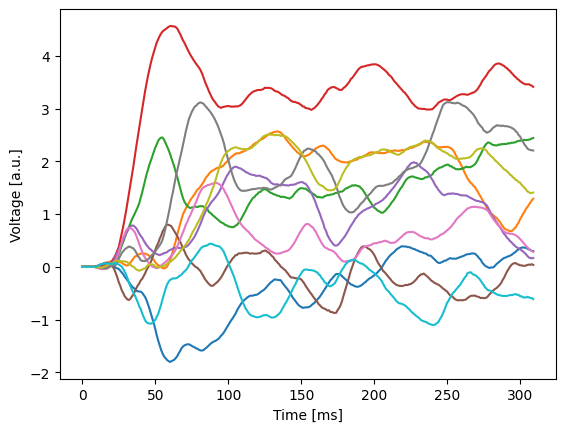

In [135]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_snn = model.snn.to(DEVICE)
frames = frames.to(DEVICE)
trained_readout_voltages = trained_snn(frames[:, :1])

plt.plot(trained_readout_voltages.squeeze(1).cpu().detach().numpy())
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()